In [4]:
import json
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets import ImputationDataset, find_padding_masks

**Autoregressive denoiosing**

In [5]:
# Read in train and validation indices

with open('../data/data_indices.json', 'r') as f:
    data_indices = json.load(f)

train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [78]:
train_dataloader = DataLoader(ImputationDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=1, shuffle=True)
val_dataloader = DataLoader(ImputationDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=1, shuffle=True)

In [79]:
x, mask, label = next(iter(train_dataloader))
x.shape, mask.shape, label.shape

(torch.Size([1, 40, 35]), torch.Size([1, 40, 35]), torch.Size([1]))

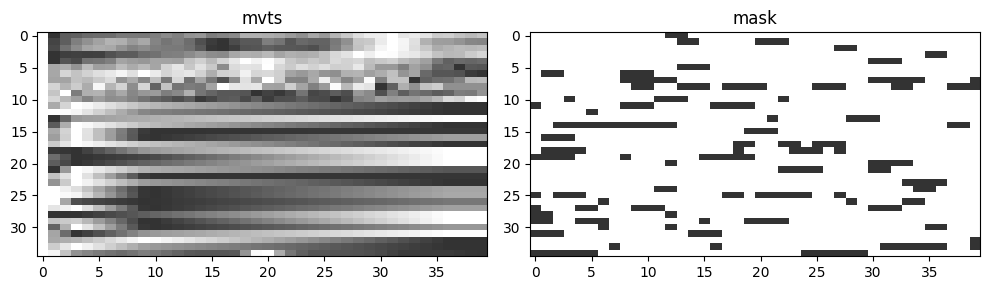

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title('mvts')
ax1.imshow(x[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax2.set_title('mask')
ax2.imshow(mask[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
plt.tight_layout()
plt.show()
plt.close()

In [82]:
padding_masks = find_padding_masks(x) 
padding_masks.shape

torch.Size([1, 40])

In [83]:
padding_masks

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])